In [39]:
import spacy
import itertools
import multiprocessing
from collections import Counter

import gensim
from gensim import corpora
from gensim.models import Word2Vec

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import shap

# Import custom code
import sys
sys.path.append('../../')
from notebooks import helper as hp


# Set plotting parameter and style
plt.rcParams['figure.figsize'] = 25, 15
plt.style.use('ggplot')

In [2]:
hotel_reviews = pd.read_csv('../../data/raw/tripadvisor_hotel_reviews.csv')
hotel_reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
hotel_reviews['Review'].sample(10).tolist()

["wonderful place stay younger daughter just returned 10 days barcelona rome spent total 6 nights hotel colon n't pleased, came spend christmas older daughter studying year university barcelona, hotel extremely convenient lives just couple blocks away, close walked took metro, lobby huge staff fell helping luggage questions rooms spacious especially european standards, rooms nicer resorts vegas smaller, 4 nights nice double room slight view cathedral plaza little balcony, angled close, cathedral covered scaffolding did n't pay extra facing room, bathroom large enormous robes slippers basket toiletries, window shut quiet cracked open window room bit warm did n't way control, left rome 3 days stayed hotel sonya n't greatest returned barcelona hotel colon 2 nights, 2nd time bigger room sitting area, no view, complaint room bathroom lighting pretty dismal, extremely pleased hotel location price amenities staff wonderful, definitely stay return barcelona,  ",
 'breezes punta cana no idea pe

Looks like some basic text processing has already been performed on the data. The sentence themselve can be somewhat difficult to comprehend. A quick inspection, I didn't see any review in other language.

In [4]:
hotel_reviews.shape

(20491, 2)

# Rating Analysis

5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: Rating, dtype: float64


<AxesSubplot:>

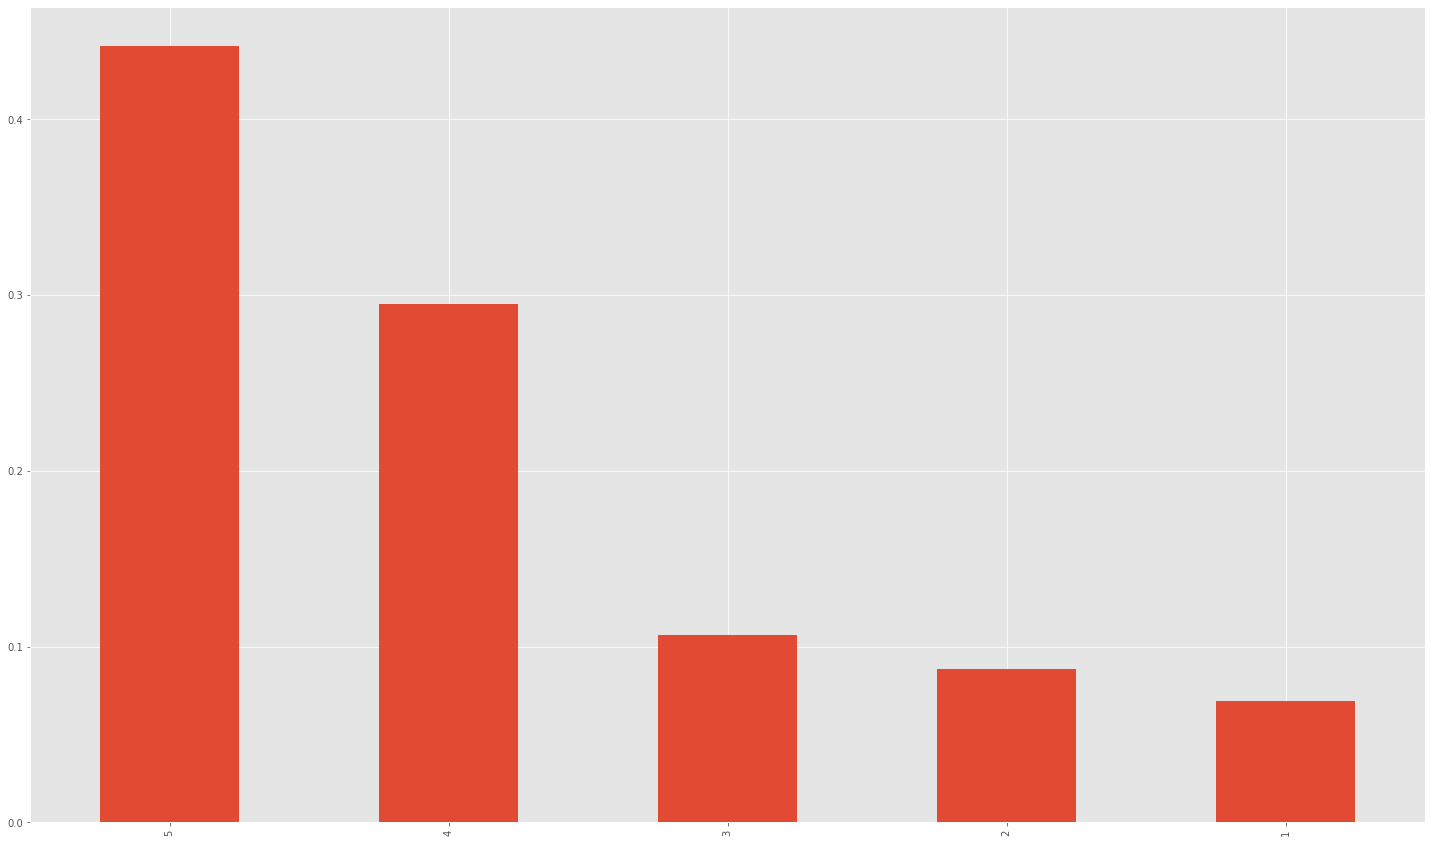

In [5]:
rating_value_pct = hotel_reviews.Rating.value_counts()/len(hotel_reviews)
print(rating_value_pct)
rating_value_pct.plot.bar()

Looks like there are a lot more positive reviews (73.5%) than negative reviews. This shows that the **self-selection bias** is likely to be present here.

# Review analysis

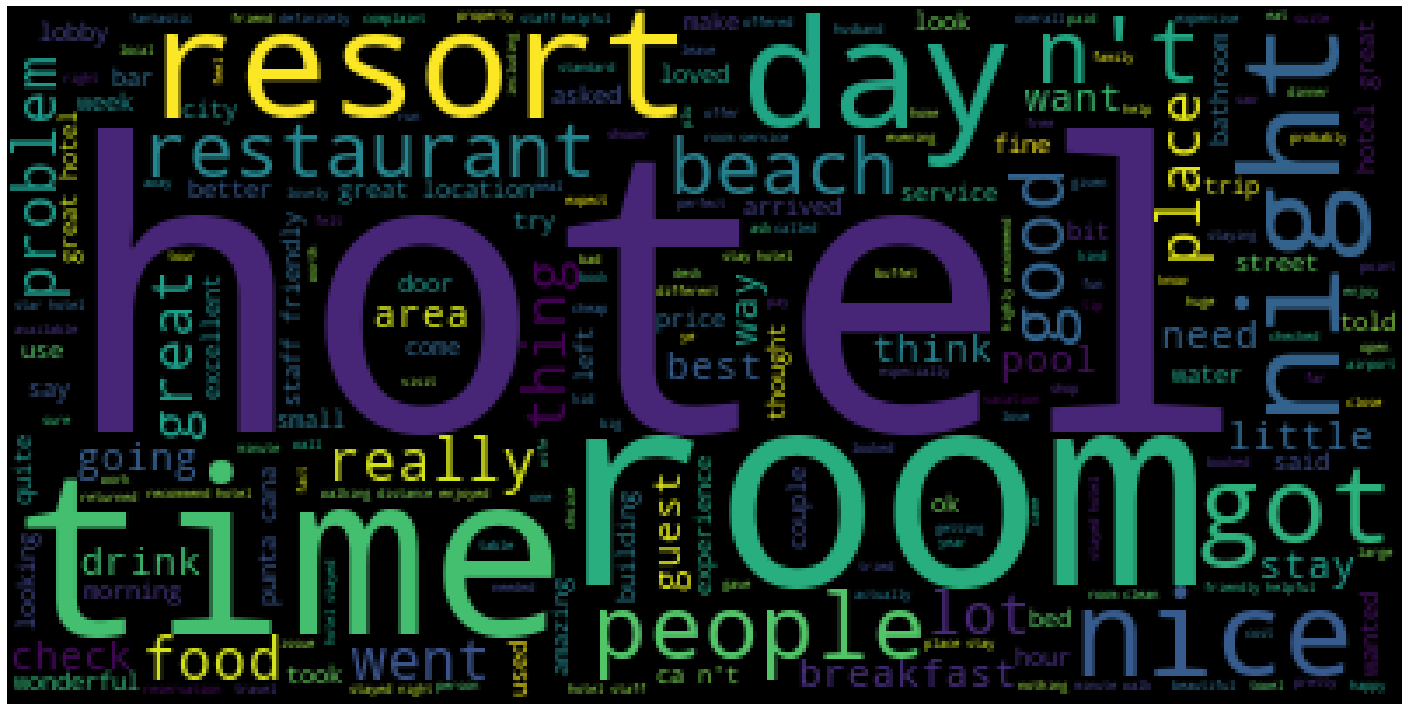

In [6]:
text = ' '.join(hotel_reviews['Review'])
hp.generate_wordcloud(text)

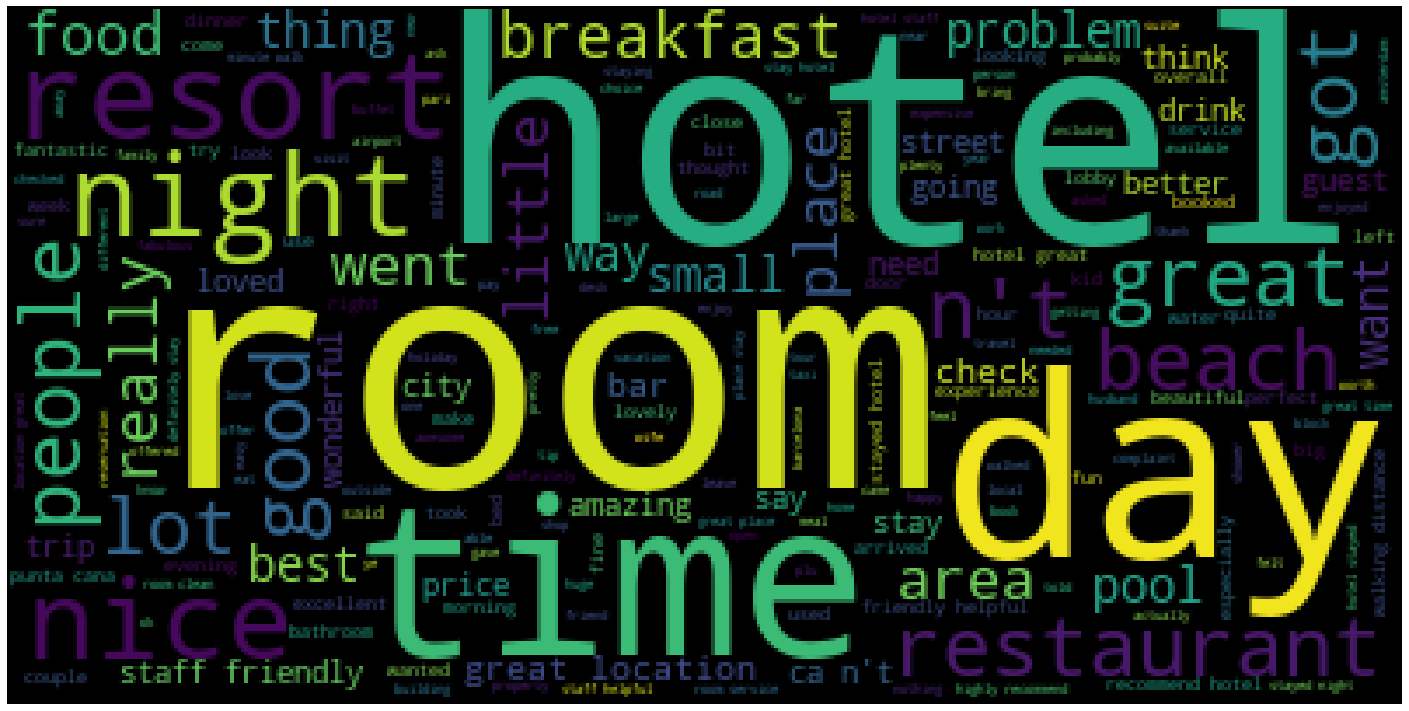

In [7]:
good_reviews = hotel_reviews[hotel_reviews['Rating'] > 3]
text = ' '.join(good_reviews['Review'])
hp.generate_wordcloud(text)

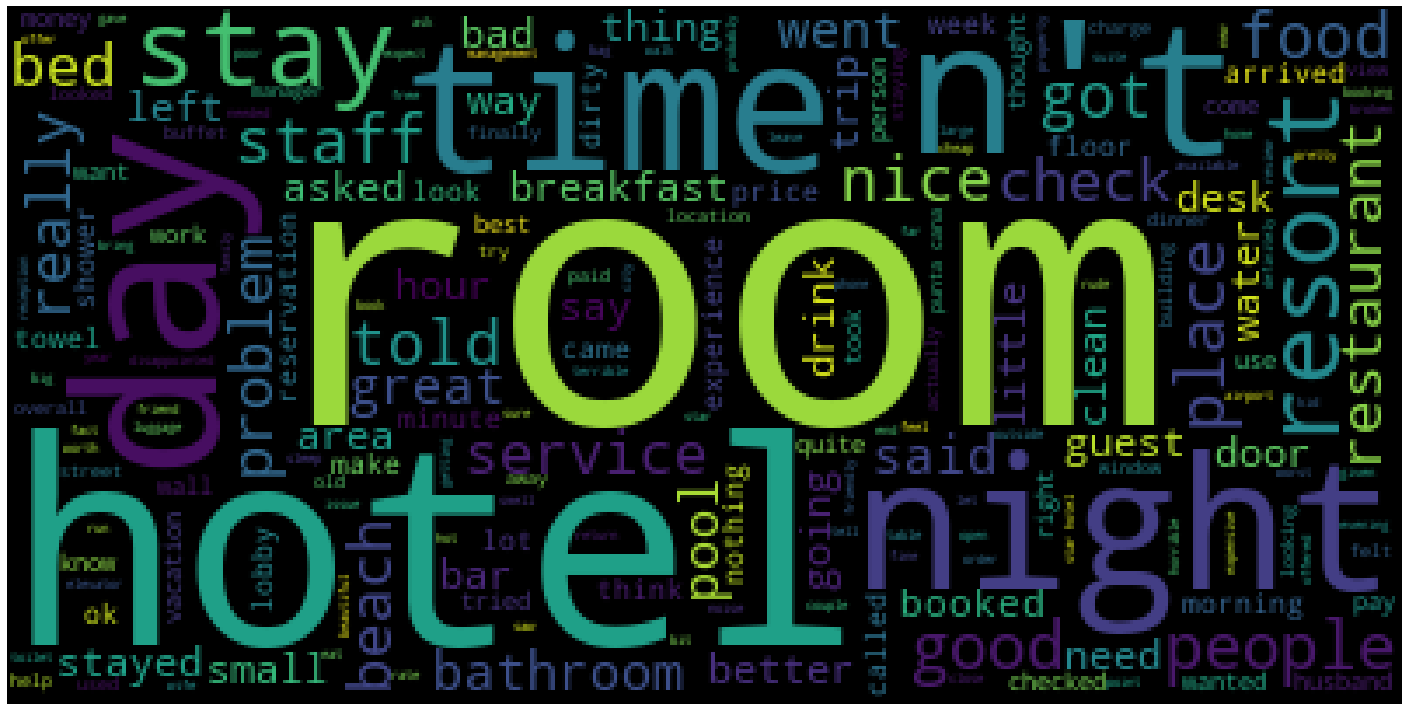

In [8]:
bad_reviews = hotel_reviews[hotel_reviews['Rating'] < 3]
text = ' '.join(bad_reviews['Review'])
hp.generate_wordcloud(text)

There isn't too much difference between the good and bad review word cloud, this is largely because the key words such as `hotel`, `room`, `people` overwhelmed the adjectives such as horrible. One way to perhaps visualise or identify problems would be to extract only the adjectives using POS and then visualise it again.

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])

In [10]:
parsed_doc = [doc for doc in nlp.pipe(hotel_reviews['Review'].tolist())]

In [11]:
nlp.vocab.length

10442

# Other processing considerations

Given the tasks:

* perhaps we should remove entities such as geographical location.
* remove adjectives as we don't need them for sentiment prediction.
* drop country/city name such as "seattle".

## Tokenise the text

At this step we only keep alphabets and also remove stop words

In [12]:
tokenised_review = [[token.lower_ for token in review if not token.is_stop and token.is_alpha and len(token.text) > 2] for review in parsed_doc]

# Create top tokens and also count the frequencies of the tokens

In [13]:
flattened_review_token = [i for i in itertools.chain.from_iterable(tokenised_review)]
review_count = Counter(flattened_review_token)
top_token = [t for t, count in review_count.most_common(500)]

<AxesSubplot:>

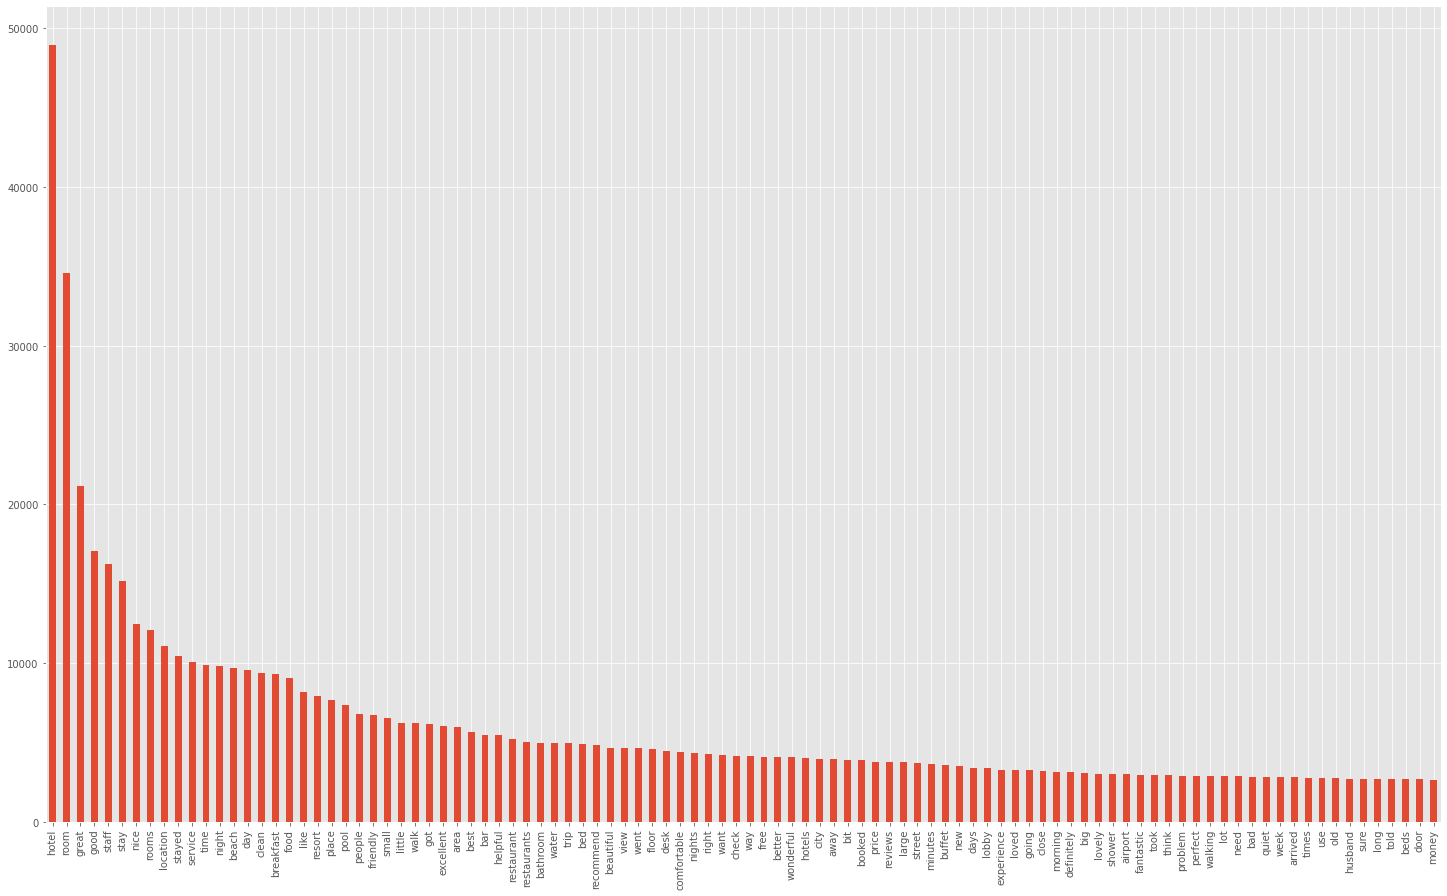

In [14]:
pd.Series({t:count for t, count in review_count.most_common(100)}).plot.bar()

# Task 1: 

**Using the words in the reviews, what major clusters (ca. 5-10) of user needs would you identify in the hotel space.**

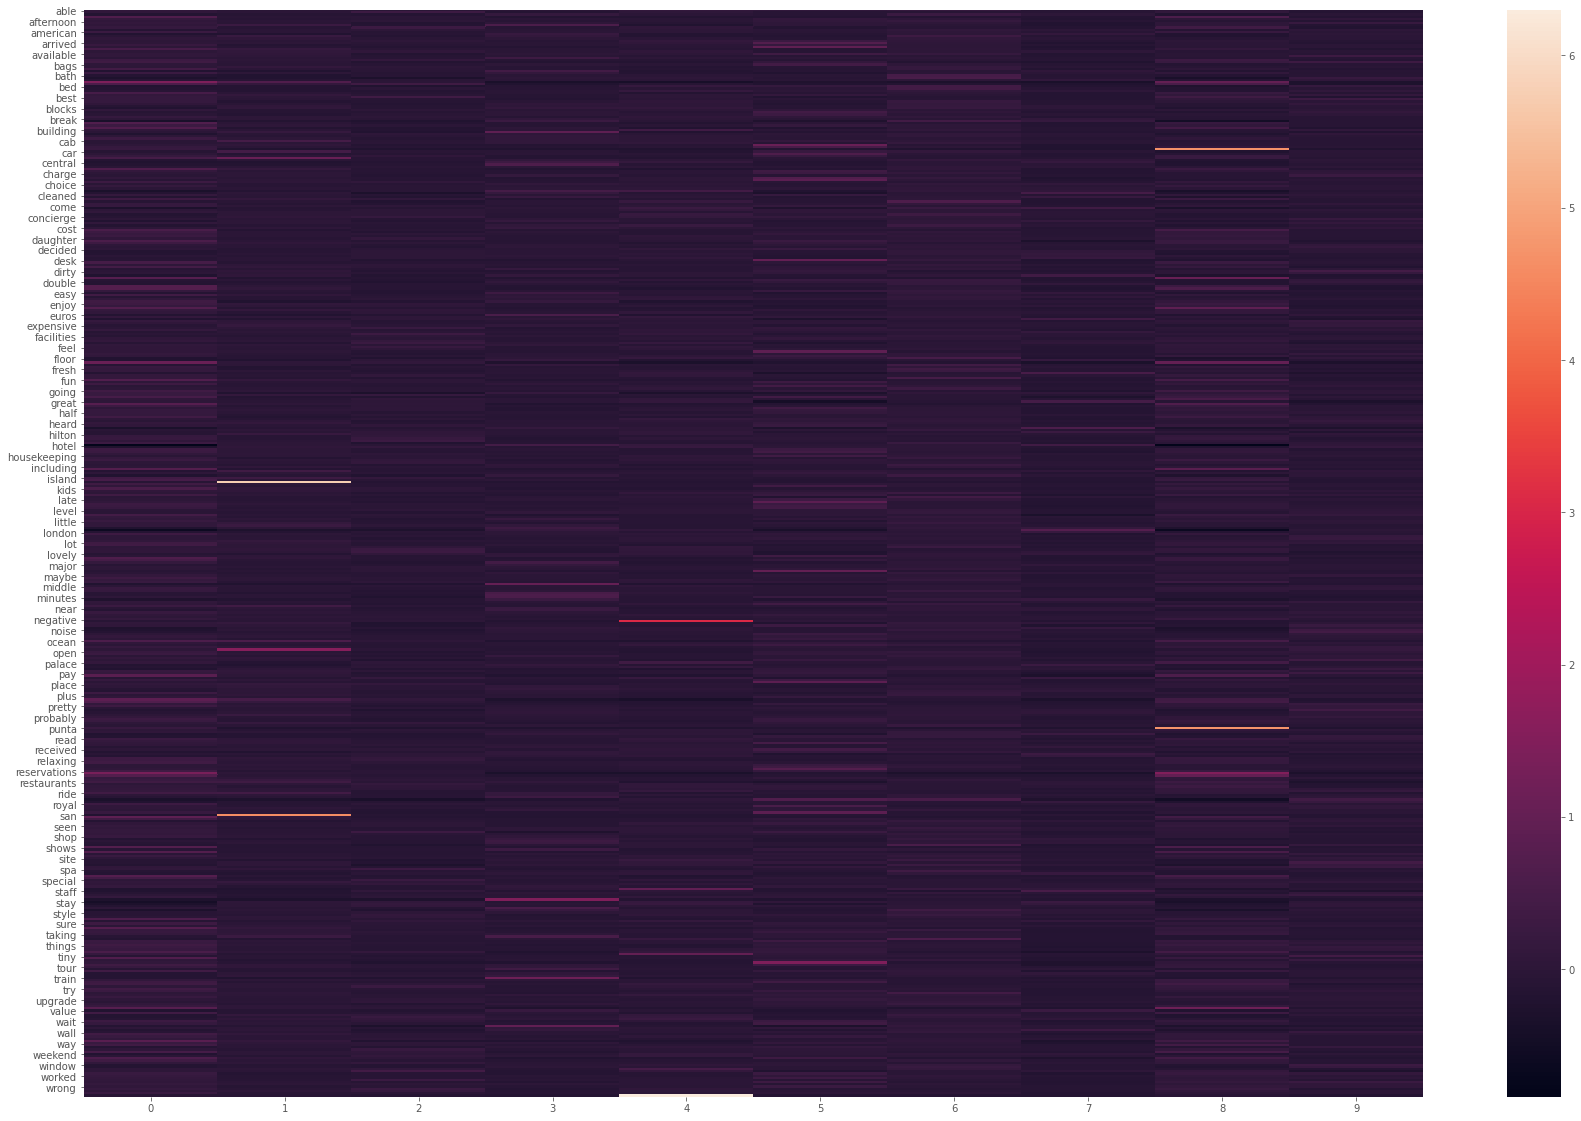

In [15]:
rc = hp.ReviewClusterer(
    n_features=500,
    n_clusters=10
)
rc.fit(hotel_reviews['Review'])
rc.visualise_cluster()

In [16]:
rc.inspect_cluster_keywords(k=10)

cluster 0: grounds + vacation + dominican + water + people + pool + sand + food + resort + beach
cluster 1: ride + car + cab + pool + ocean + beach + casino + old + san + juan
cluster 2: service + loved + absolutely + amazing + fabulous + spa + honeymoon + beautiful + best + wonderful
cluster 3: euros + airport + minutes + minute + centre + bus + walk + metro + train + station
cluster 4: visit + comfortable + palace + building + city + wine + square + times + new + york
cluster 5: checked + later + phone + said + finally + asked + desk + manager + called + told
cluster 6: bed + large + fruit + bath + floor + room + shower + bathroom + tea + coffee
cluster 7: comfortable + hotel + distance + excellent + clean + great + staff + friendly + helpful + location
cluster 8: inclusive + entertainment + beach + resorts + food + dominican + vacation + resort + cana + punta
cluster 9: average + noise + bad + paid + price + room + tiny + sleep + noisy + dirty


# Task 2: 

**For the clusters above, are there any needs that you would rate as more critical / important than others? Do you see any clear areas that hotels absolutely need to focus on in order to do well.**

I don't know if the cluster allow us to identify or prioritise based on the cluster. But let's dig a bit deeper into the reviews.


In [17]:
normalised_review = rc.pipeline[:2].transform(hotel_reviews['Review'])

## Use Catboost to explain and understand what are the keywords that are associated with positive and negative reviews.

In [18]:
non_neutral_review = hotel_reviews[hotel_reviews['Rating'] != 3]
vectorised_review = rc.pipeline[:2].transform(non_neutral_review['Review'])
multi_class_ratings = non_neutral_review['Rating'].map({5:1, 4:1, 2:0, 1:0})

<AxesSubplot:>

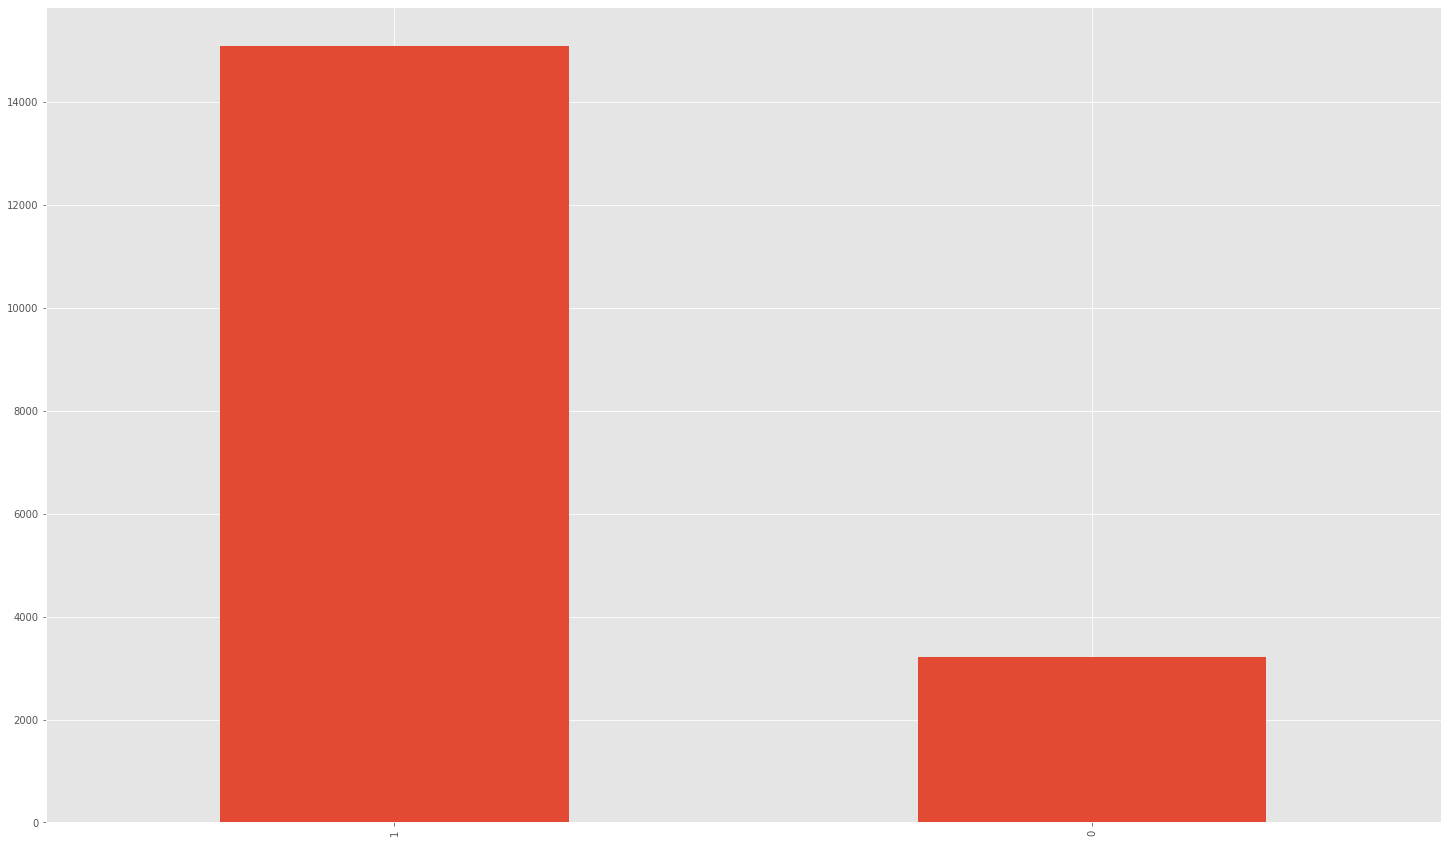

In [19]:
multi_class_ratings.value_counts().plot.bar()

Just like what we have seen before, there is an overwhelming imbalance in the data towards positive reviews.

In [20]:
vectorised_review.shape

(18307, 500)

In [21]:
feature_names = rc.pipeline.named_steps['vectoriser'].get_feature_names()
vectorised_review_df = pd.DataFrame(vectorised_review, columns=feature_names)
train_x, test_x, train_y, test_y = train_test_split(vectorised_review_df, multi_class_ratings.values)

In [22]:
# create a simple weighting schema
frequency = pd.Series(train_y).value_counts()
simple_weight_mapping = (1/(frequency/frequency.max())).to_dict()
simple_weight = pd.Series(train_y).map(simple_weight_mapping)

In [23]:
train_pool = catboost.Pool(data=train_x, label=train_y, weight=simple_weight)
test_pool = catboost.Pool(test_x, test_y)

In [24]:

classifier = catboost.CatBoostClassifier(
    loss_function='CrossEntropy',
    depth=5
)
classifier.fit(train_pool, eval_set=test_pool, verbose=False)


In [25]:
confusion_matrix(train_y, classifier.predict(train_pool))

array([[ 2382,    17],
       [  581, 10750]])

In [26]:
print(classification_report(train_y, classifier.predict(train_pool)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      2399
           1       1.00      0.95      0.97     11331

    accuracy                           0.96     13730
   macro avg       0.90      0.97      0.93     13730
weighted avg       0.96      0.96      0.96     13730



Looks like we have a descent model.

In [27]:
shap.initjs()

In [28]:
explainer = shap.Explainer(classifier)
shap_value = explainer.shap_values(train_pool)

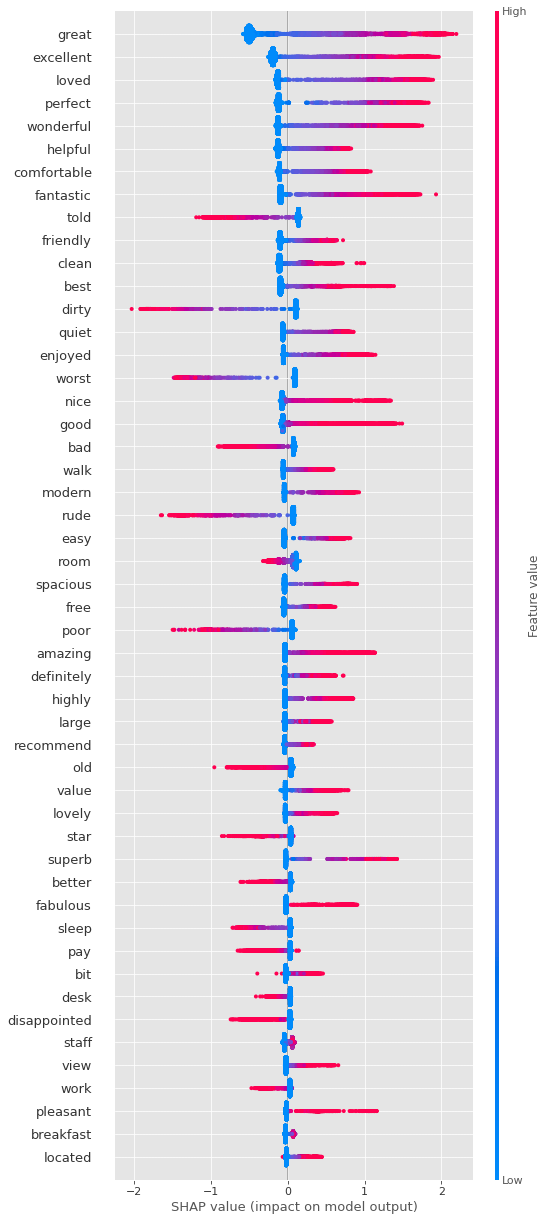

In [29]:
shap.summary_plot(shap_value, train_x, max_display=50)

Here are some selected keywords that are associated with negative responses:

* told/asked
* dirty
* rude
* sleep

It is clear that these negative response appear are a response to non-responses from the hotel. They have told or asked the hotel to address the issue, but have not and thus resort to negative reviews to express their frustration or disappointment.

Then there are basic expectations. Having clean room, well-mannered staff and good sleep are bare necessity of a hotel.

In [30]:
index = 0
print(train_y[index])
shap.force_plot(explainer.expected_value, shap_value[index, :], train_x.iloc[index, :])


1


In [31]:
index = 506
print(train_y[index])
shap.force_plot(explainer.expected_value, shap_value[index, :], train_x.iloc[index, :])


1


# Additional Explorations: Topic Model

In [32]:
dictionary = corpora.Dictionary(tokenised_review)
dictionary.filter_extremes(no_below=200, no_above=0.2)
corpus = [dictionary.doc2bow(text) for text in tokenised_review]

In [33]:
NUM_TOPICS = 20
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus, 
    num_topics=NUM_TOPICS, 
    id2word=dictionary, 
    passes=20, 
    iterations=500,
    random_state=587, 
    chunksize=500)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.045*"station" + 0.030*"bus" + 0.026*"metro" + 0.023*"minutes" + 0.023*"away"')
(1, '0.014*"went" + 0.013*"left" + 0.013*"going" + 0.012*"way" + 0.012*"sure"')
(2, '0.103*"reviews" + 0.085*"suite" + 0.049*"read" + 0.041*"surprised" + 0.036*"booked"')
(3, '0.051*"check" + 0.046*"arrived" + 0.035*"airport" + 0.023*"luggage" + 0.023*"took"')
(4, '0.020*"internet" + 0.020*"modern" + 0.017*"free" + 0.016*"business" + 0.015*"city"')
(5, '0.041*"restaurants" + 0.026*"restaurant" + 0.026*"tour" + 0.024*"trip" + 0.020*"san"')
(6, '0.042*"fantastic" + 0.033*"value" + 0.032*"lovely" + 0.029*"view" + 0.023*"pool"')
(7, '0.035*"new" + 0.032*"family" + 0.023*"hotels" + 0.018*"old" + 0.017*"property"')
(8, '0.059*"wonderful" + 0.057*"loved" + 0.048*"beautiful" + 0.034*"amazing" + 0.029*"perfect"')
(9, '0.030*"star" + 0.025*"better" + 0.018*"bad" + 0.016*"think" + 0.015*"hotels"')
(10, '0.073*"floor" + 0.072*"noise" + 0.043*"street" + 0.033*"noisy" + 0.029*"view"')
(11, '0.190*"walking" + 0.111*

I mean, there are some good topics and "pseudo-clusters" here.

In [34]:
good_review = hotel_reviews[hotel_reviews['Rating'] > 3]['Review'].tolist()

good_review_nlp = spacy.load('en_core_web_sm', disable=['ner'])
tokenised_good_review = [[token.lower_ for token in review
                          if not token.is_stop
                          and token.is_alpha
                          and len(token.text) > 2]
                         for review in good_review_nlp.pipe(good_review)]

good_review_dictionary = corpora.Dictionary(tokenised_good_review)
good_review_dictionary.filter_extremes(no_below=200, no_above=0.2)
good_review_corpus = [good_review_dictionary.doc2bow(text) for text in tokenised_good_review]

good_review_ldamodel = gensim.models.ldamodel.LdaModel(
    good_review_corpus, 
    num_topics=NUM_TOPICS, 
    id2word=dictionary, 
    passes=20, 
    iterations=500,
    random_state=587, 
    chunksize=500)
good_review_topics = good_review_ldamodel.print_topics(num_words=5)
for topic in good_review_topics:
    print(topic)
    


(0, '0.020*"reviews" + 0.016*"shop" + 0.015*"pay" + 0.014*"showed" + 0.012*"manager"')
(1, '0.072*"booked" + 0.051*"bottle" + 0.035*"bright" + 0.025*"bugs" + 0.022*"bedroom"')
(2, '0.037*"short" + 0.030*"overall" + 0.028*"westin" + 0.024*"dining" + 0.022*"offer"')
(3, '0.033*"easily" + 0.026*"check" + 0.020*"arrived" + 0.018*"changed" + 0.017*"talking"')
(4, '0.050*"turn" + 0.049*"buildings" + 0.045*"priced" + 0.026*"returning" + 0.024*"convenient"')
(5, '0.033*"asking" + 0.028*"hope" + 0.027*"ready" + 0.025*"business" + 0.022*"chocolate"')
(6, '0.124*"near" + 0.057*"rates" + 0.056*"overlooking" + 0.040*"ran" + 0.035*"speak"')
(7, '0.154*"usual" + 0.069*"changed" + 0.067*"lack" + 0.053*"smell" + 0.052*"honeymoon"')
(8, '0.055*"sure" + 0.031*"temperature" + 0.029*"extra" + 0.028*"sorry" + 0.025*"blocks"')
(9, '0.030*"hotels" + 0.026*"package" + 0.016*"group" + 0.015*"stylish" + 0.014*"informed"')
(10, '0.035*"decided" + 0.028*"getting" + 0.022*"better" + 0.021*"men" + 0.021*"sunday"')
(

In [35]:
bad_review = hotel_reviews[hotel_reviews['Rating'] < 3]['Review'].tolist()

bad_review_nlp = spacy.load('en_core_web_sm', disable=['ner'])
tokenised_bad_review = [[token.lower_ for token in review
                          if not token.is_stop
                          and token.is_alpha
                          and len(token.text) > 2]
                         for review in bad_review_nlp.pipe(bad_review)]

bad_review_dictionary = corpora.Dictionary(tokenised_bad_review)
bad_review_dictionary.filter_extremes(no_below=200, no_above=0.2)
bad_review_corpus = [bad_review_dictionary.doc2bow(text) for text in tokenised_bad_review]

bad_review_ldamodel = gensim.models.ldamodel.LdaModel(
    bad_review_corpus, 
    num_topics=5, 
    id2word=dictionary, 
    passes=20, 
    iterations=500,
    random_state=587, 
    chunksize=500,
    alpha='auto', 
    eta='auto')
bad_review_topics = bad_review_ldamodel.print_topics(num_words=5)
for topic in bad_review_topics:
    print(topic)
    


(0, '0.079*"wine" + 0.042*"thought" + 0.025*"seattle" + 0.022*"far" + 0.021*"wonderful"')
(1, '0.024*"showed" + 0.023*"unlike" + 0.018*"told" + 0.017*"things" + 0.017*"screen"')
(2, '0.040*"sitting" + 0.030*"convenient" + 0.028*"water" + 0.028*"send" + 0.024*"start"')
(3, '0.046*"sorry" + 0.044*"deal" + 0.034*"heard" + 0.033*"super" + 0.032*"booked"')
(4, '0.028*"previous" + 0.020*"anniversary" + 0.018*"asked" + 0.016*"advice" + 0.016*"size"')


# Additional Exploration: Cluster on embedding

In [36]:
EMBEDDING_SIZE = 100
CORES = multiprocessing.cpu_count()
WINDOW_SIZE = 2
MIN_COUNT = 5

w2v_model = Word2Vec(min_count=MIN_COUNT,
                     sg=0,
                     hs=0,
                     ns_exponent=0.75,
                     negative=20,
                     window=WINDOW_SIZE,
                     size=EMBEDDING_SIZE,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     workers=CORES-1,
                     compute_loss=True)
w2v_model.build_vocab(tokenised_review, progress_per=100)
w2v_model.train(tokenised_review, total_examples=w2v_model.corpus_count,
                epochs=30, report_delay=1)

(28284483, 57263550)

In [40]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, 
           perplexity=10,
           learning_rate=10,
           n_iter=5000,
           early_exaggeration=10,
           verbose=1)
dimension_reduction_pipeline = Pipeline(steps=[('pca', pca), ('tsne', tsne)])

In [42]:
dr_embedding = dimension_reduction_pipeline.fit_transform(w2v_model.wv.vectors)
dr_embedding_df = pd.DataFrame(dr_embedding, columns=['x', 'y']).assign(labels=w2v_model.wv.vocab)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 13695 samples in 0.124s...
[t-SNE] Computed neighbors for 13695 samples in 27.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13695
[t-SNE] Computed conditional probabilities for sample 2000 / 13695
[t-SNE] Computed conditional probabilities for sample 3000 / 13695
[t-SNE] Computed conditional probabilities for sample 4000 / 13695
[t-SNE] Computed conditional probabilities for sample 5000 / 13695
[t-SNE] Computed conditional probabilities for sample 6000 / 13695
[t-SNE] Computed conditional probabilities for sample 7000 / 13695
[t-SNE] Computed conditional probabilities for sample 8000 / 13695
[t-SNE] Computed conditional probabilities for sample 9000 / 13695
[t-SNE] Computed conditional probabilities for sample 10000 / 13695
[t-SNE] Computed conditional probabilities for sample 11000 / 13695
[t-SNE] Computed conditional probabilities for sample 12000 / 13695
[t-SNE] Computed conditional probabilities for sa

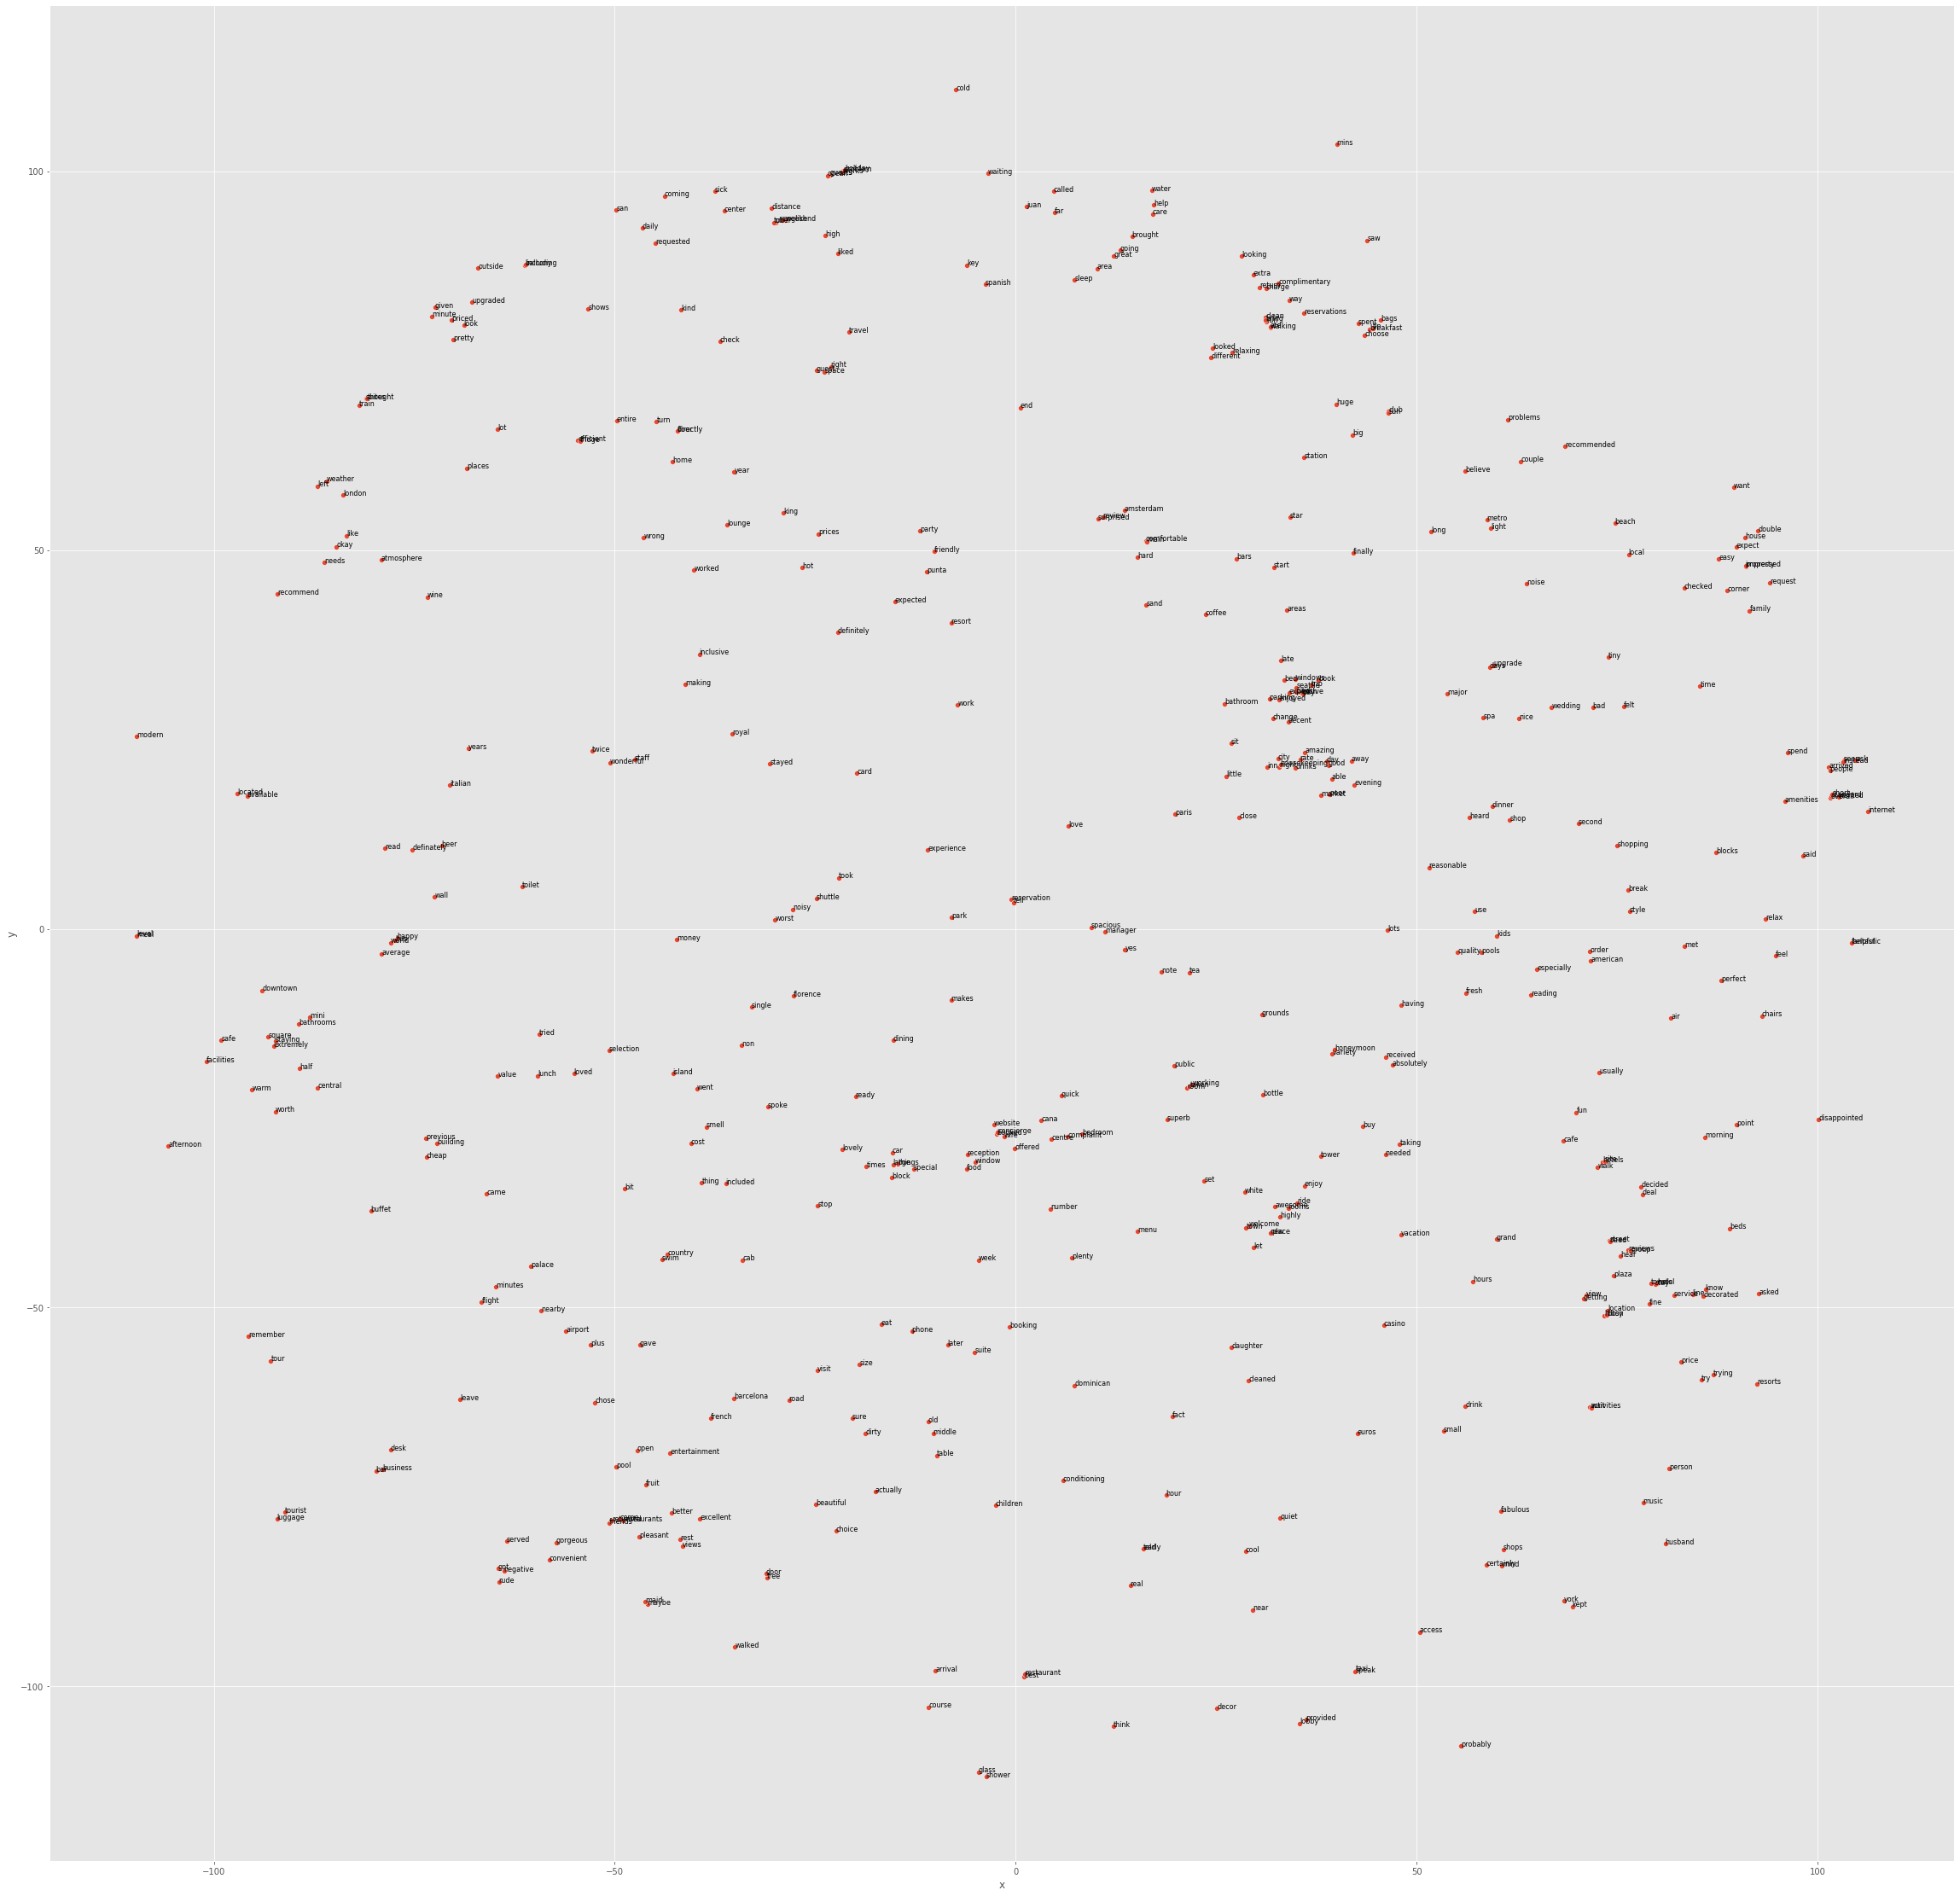

In [43]:
#import numpy as np
plot_df = dr_embedding_df[dr_embedding_df['labels'].isin(top_token)]
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.scatterplot(data=plot_df, x='x', y='y')
for ind, obs in plot_df.iterrows():
    #ax.text(x=obs['x'] + np.random.normal(1, 1), y=obs['y'] + np.random.normal(1, 1), s=obs['labels'], fontsize=8)
    ax.text(x=obs['x'], y=obs['y'], s=obs['labels'], fontsize=8)

In [44]:
fig.savefig('review_embedding.png', bbox_inches='tight')